In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Model

In [2]:
model = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
model.trainable = False
decode_predictions = tf.keras.applications.mobilenet.decode_predictions

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Pre process

In [3]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  if tf.reduce_max(image) <= 1.0:
        image = image * 255.0
  image = tf.keras.applications.mobilenet.preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [4]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [5]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [7]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
#   image = preprocess(image)
  return image

In [8]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    'Green Mamba': 'https://storage.googleapis.com/cvstock-932a9.appspot.com/thumbnail-P3XMTBB3Y8E1'
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}
indices = [555, 389, 64]

3954129/3954129 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
802859/802859 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


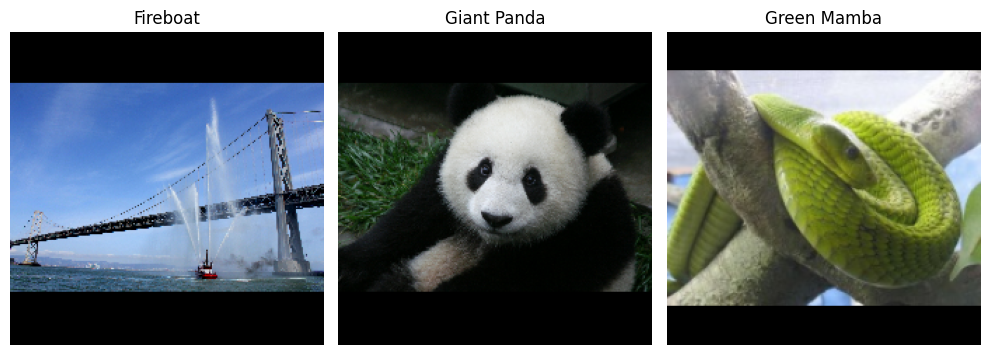

In [9]:
plt.figure(figsize=(10, 16))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 3, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [10]:
def top_k_predictions(img, k=3):
    probs = model.predict(img)
    return decode_predictions(probs, top=k)[0]

# Top 3 predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


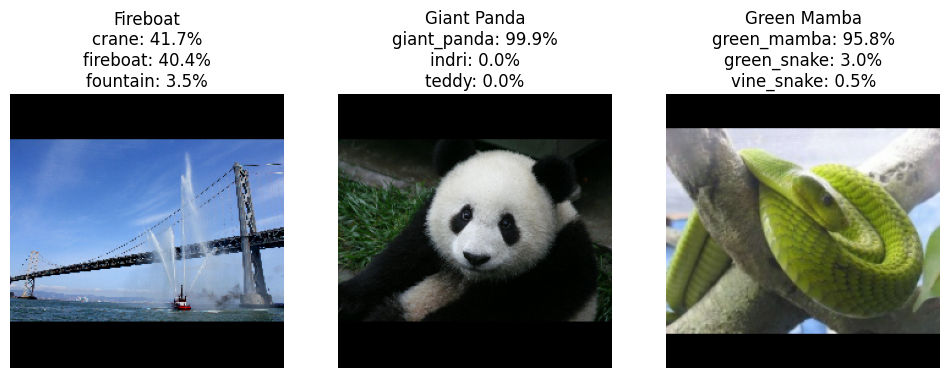

In [11]:
plt.figure(figsize=(12, 8))
for i, (name, img_tensor) in enumerate(img_name_tensors.items()):
    img = tf.convert_to_tensor(img_tensor)
    img = preprocess(img)
    preds = top_k_predictions(img)
    label_str = "\n".join([f"{label}: {prob:.1%}" for (_, label, prob) in preds])
    plt.subplot(1, 3, i + 1)
    plt.imshow(img_tensor)
    plt.title(f'{name}\n{label_str}')
    plt.axis('off')
    # for class_id, label, prob in preds:
    #     print(f"{label}: {prob:.2f}")
plt.show()

In [12]:
adversarial_patterns = {}
for i, (name, img_tensor) in enumerate(img_name_tensors.items()):
    img_tensor = preprocess(img_tensor)
    image_probs = model.predict(img_tensor)
    label = tf.one_hot(indices[i], image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    adversarial_pattern = create_adversarial_pattern(input_image=img_tensor, input_label=label)
    adv_x = img_tensor + 0.1 * adversarial_pattern
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    adversarial_patterns[name] = adv_x[0] * 0.5 + 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


# Top 3 prediction with adversarial

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


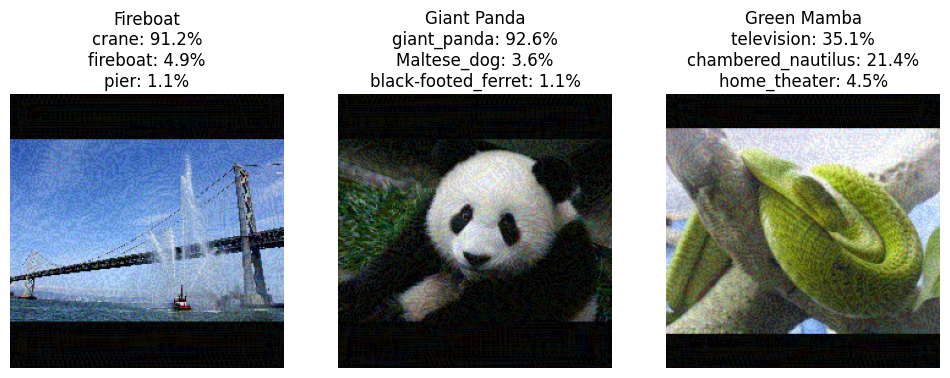

In [13]:
plt.figure(figsize=(12, 8))
for i, (name, adv_x) in enumerate(adversarial_patterns.items()):
    img = tf.convert_to_tensor(adv_x)
    img = preprocess(img)
    preds = top_k_predictions(img)
    label_str = "\n".join([f"{label}: {prob:.1%}" for (_, label, prob) in preds])
    plt.subplot(1, 3, i + 1)
    plt.imshow(adv_x)
    plt.title(f'{name}\n{label_str}')
    plt.axis('off')
plt.show()

# Baseline

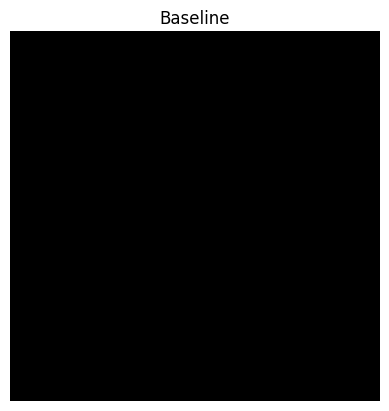

In [14]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [15]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

# Considering softmax

In [18]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        target_logit = logits[:, target_class_idx]
    return tape.gradient(target_logit, images)

In [19]:
def integral_approximation(gradients):
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [20]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    return gradient_batch

def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    gradient_batches = []
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    total_gradients = tf.concat(gradient_batches, axis=0)
    avg_gradients = integral_approximation(gradients=total_gradients)
    integrated_gradients = (image - baseline) * avg_gradients
    return integrated_gradients

def plot_img_attributions(baseline, image, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4, img_type=''):

    attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, m_steps=m_steps)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(12, 8))

    axs[0, 0].set_title(f'Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title(f'Original image {img_type}')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[0, 2].set_title(f'Attribution mask {img_type}')
    axs[0, 2].imshow(attribution_mask, cmap=cmap)
    axs[0, 2].axis('off')

    axs[0, 3].set_title(f'Overlay {img_type}')
    axs[0, 3].imshow(attribution_mask, cmap=cmap)
    axs[0, 3].imshow(image, alpha=overlay_alpha)
    axs[0, 3].axis('off')

    plt.tight_layout()
    return fig

# IG on original and adversarial images

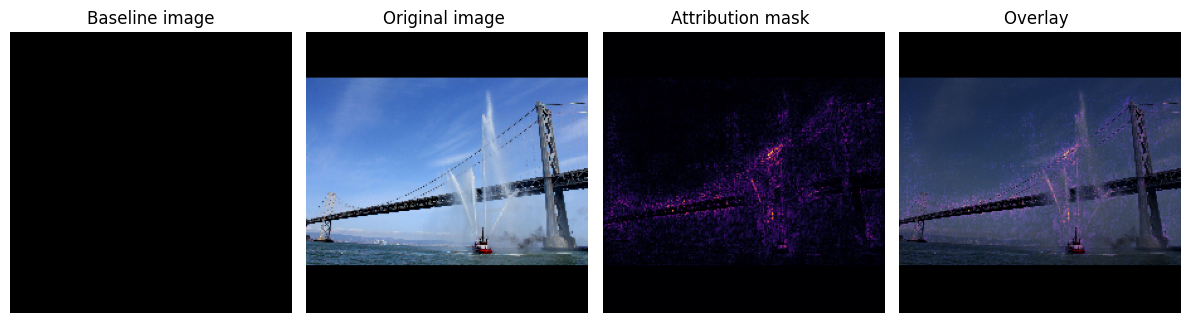

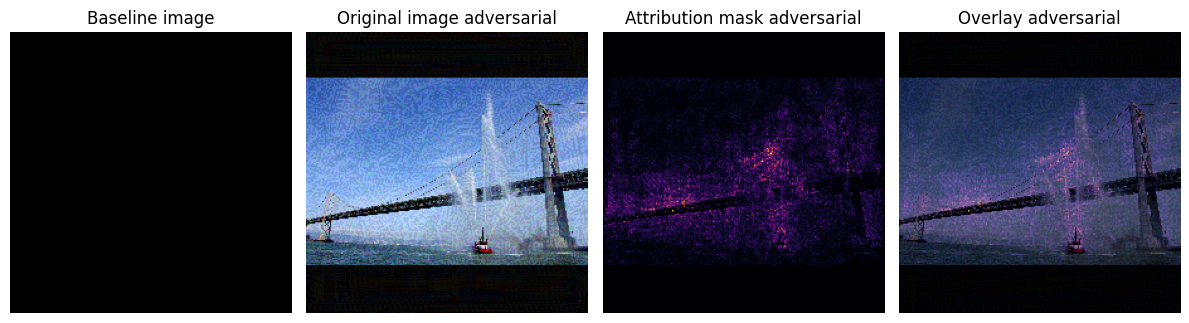

In [21]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'], baseline=baseline, target_class_idx=555, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)
_ = plot_img_attributions(image=adversarial_patterns['Fireboat'], baseline=baseline, target_class_idx=555, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4, img_type='adversarial')

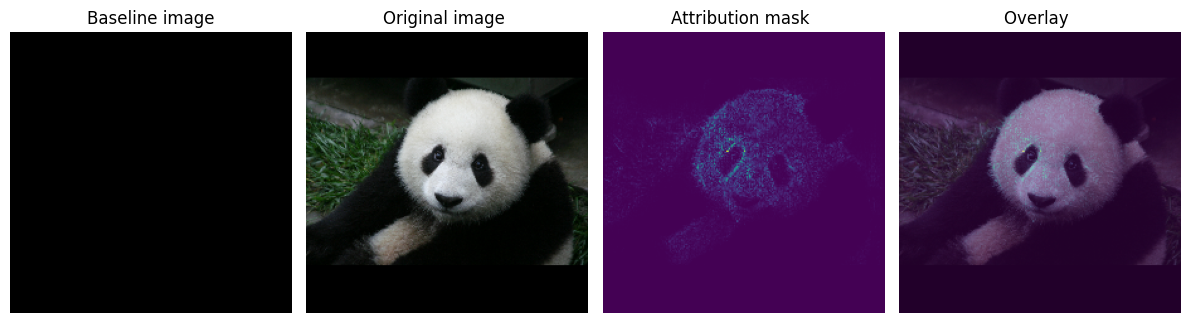

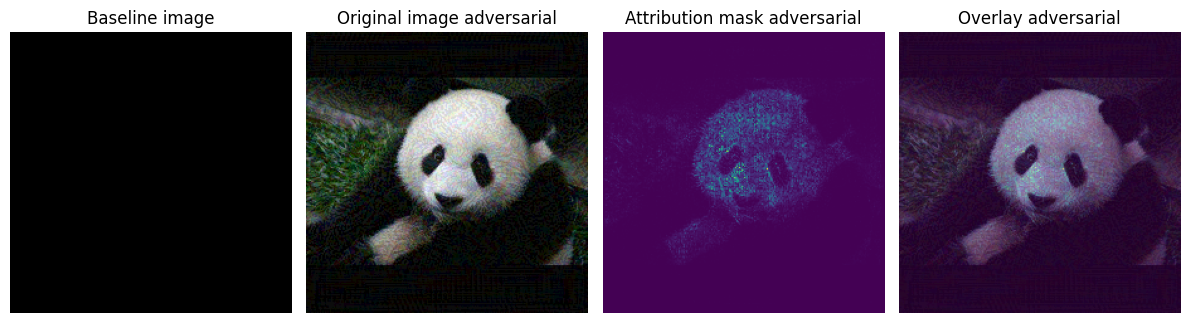

In [22]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'], baseline=baseline, target_class_idx=389, m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5)
_ = plot_img_attributions(image=adversarial_patterns['Giant Panda'], baseline=baseline, target_class_idx=389, m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5, img_type='adversarial')


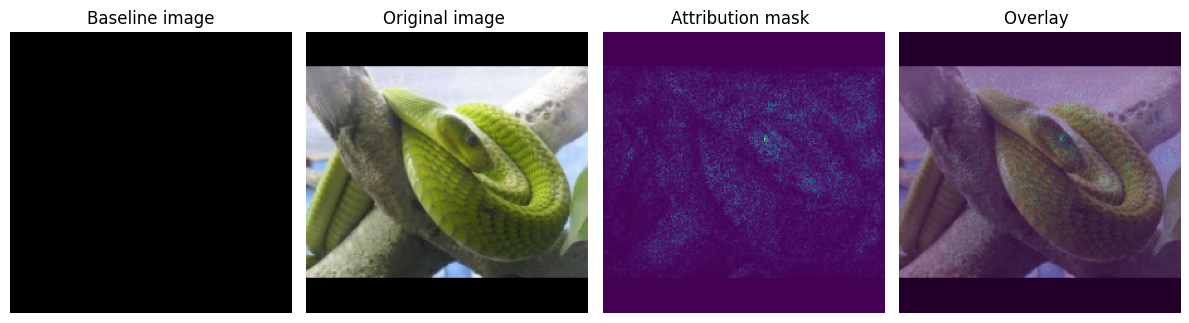

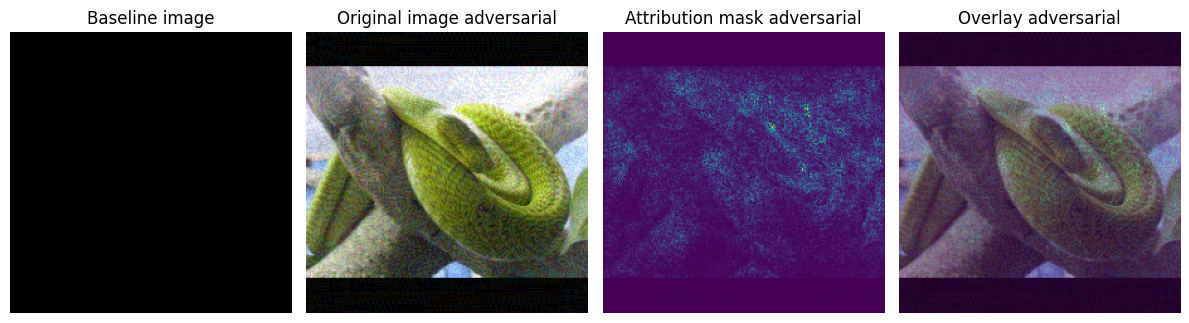

In [23]:
_ = plot_img_attributions(image=img_name_tensors['Green Mamba'], baseline=baseline, target_class_idx=64, m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5)
_ = plot_img_attributions(image=adversarial_patterns['Green Mamba'], baseline=baseline, target_class_idx=64, m_steps=55, cmap=plt.cm.viridis, overlay_alpha=0.5, img_type='adversarial')


# GradCam considering softmax

In [24]:
import cv2
def compute_gradcam(model, img_tensor, class_idx, layer_name='conv_pw_13_relu'):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        probs = tf.nn.softmax(predictions, axis=-1)
        loss = probs[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_heatmap(image, heatmap, alpha=0.4, cmap='jet'):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = plt.cm.get_cmap(cmap)(heatmap_resized)[..., :3]
    superimposed = heatmap_colored * alpha + image / 255.0
    return np.clip(superimposed, 0, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/tmp/ipython-input-24-1021492623.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap_colored = plt.cm.get_cmap(cmap)(heatmap_resized)[..., :3]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


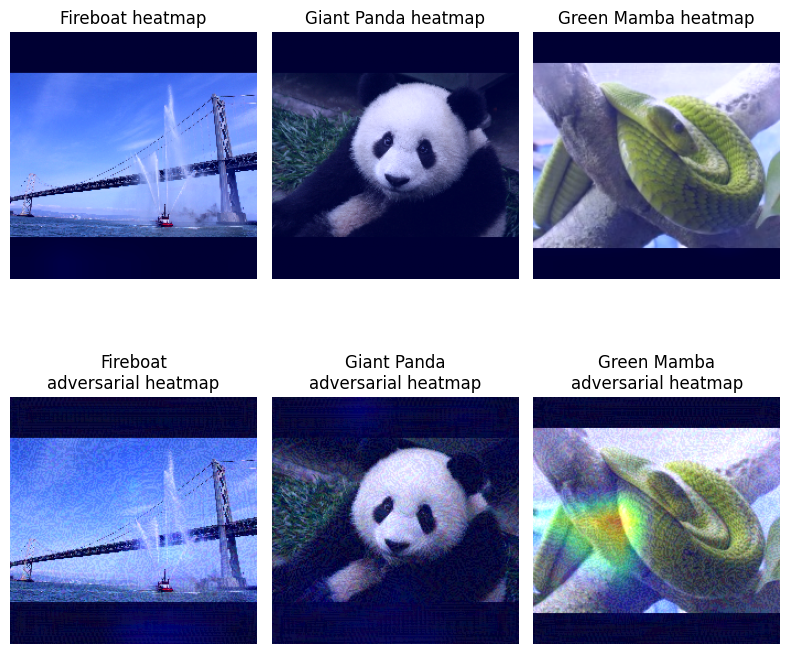

In [25]:
plt.figure(figsize=(8, 8))
for i, (name, img_tensor) in enumerate(img_name_tensors.items()):
    img = tf.convert_to_tensor(img_tensor)
    img = preprocess(img)
    preds = top_k_predictions(img)
    class_idx = np.argmax(preds[0])
    heatmap = compute_gradcam(model, img, class_idx)
    raw_img = img_tensor.numpy()
    if raw_img.max() <= 1.0:
        raw_img = (raw_img * 255).astype(np.uint8)
    overlay = overlay_heatmap(raw_img, heatmap)

    label_str = "\n".join([f"{label}: {prob:.1%}" for (_, label, prob) in preds])
    plt.subplot(2, 3, i + 1)
    plt.imshow(overlay)
    plt.title(f'{name} heatmap')
    plt.axis('off')

for i, (name, adv_x) in enumerate(adversarial_patterns.items()):
    img = tf.convert_to_tensor(adv_x)
    img = preprocess(img)
    preds = top_k_predictions(img)
    class_idx = np.argmax(preds[0])
    heatmap = compute_gradcam(model, img, class_idx)
    raw_img = adv_x.numpy()
    if raw_img.max() <= 1.0:
        raw_img = (raw_img * 255).astype(np.uint8)
    overlay = overlay_heatmap(raw_img, heatmap)

    label_str = "\n".join([f"{label}: {prob:.1%}" for (_, label, prob) in preds])
    plt.subplot(2, 3, i + 4)
    plt.imshow(overlay)
    plt.title(f'{name}\nadversarial heatmap')
    plt.axis('off')
plt.tight_layout()
plt.show()